In [1]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)
from src.preprocessing.load_data import *
from src.preprocessing.process_softchirp_features import find_outliers, choose_features
from src.data_representations.softchirp_features import compute_all_features
from src.data_representations.process_traces import clear_trace
from src.preprocessing.filters import filter_recs_metadata, filter_sounds_metadata_extended
from src.preprocessing.process_sounds_metadata import extend_sounds_metadata, compute_epochs
from src.data_analysis.softchirps_classification import classify, make_bins
from src.util import delete_indexes
from src.visualization.plot_classification_development import plot_pup_accent_development
from notebooks.analysis.plotting_config import ORDER, COLOR, EPOCHS # change plotting_config file to change colors

from joblib import dump, load

### Parameter selection, settings

In [2]:
# specify paths, where data is stored
path_to_info = PATH_TO_PROJECT + 'data/rat_info.csv'
path_to_recordings_metadata = PATH_TO_PROJECT + 'data/'
recordings_metadata_name = 'recordings_metadata.csv'

# what data to load, set filters here
colonies = ['martell', 'frog', 'bird', 'rabbit', 'targaryen']
dates = 'all'
experiments = ['single rat softchirps','baratheon epochs']
experiments = 'all'
# stage options: 'fresh', 'split', 'split and checked', 'classified', 'classified and checked', 'traced', 'traced and checked'
stages = ['traced', 'traced and checked'] # always use 'traced and checked' for naked mole-rat experiments
#stages = 'all'
# specifies seconds  to pixels ratio for spectrogram image
# must use librosa library which downsamples all audio files to 22050
freq_mult = 22050 / 2  / 128

# specify outliers,soft chirp traces outside of these ranges are excluded from analysis  
boundaries = {'slope' : (0.01, .2), 
              'frequency' : (2000, 8000), 
              'duration' : (0.05, 10),
              'height' : (300, 6000)}

### Load data

In [3]:
%%time
# load info- and meta- data
info = load_info_file(path_to_info)
recs_metadata = pd.read_csv(path_to_recordings_metadata + recordings_metadata_name, dtype={'ratids': str})

#  filter what will be used (this is specified above)
mask = filter_recs_metadata(recs_metadata, dates, colonies, stages, experiments)
recs_to_analyse = recs_metadata[mask]

# load recording wavs, sound wavs and traces, create sounds metadata (master file)
recs_dict = load_recs_dict(recs_to_analyse)
traces, wavs, sounds_metadata = load_traces_wavs_and_metadata(recs_to_analyse, info, recs_dict)
sounds_metadata_extended = extend_sounds_metadata(sounds_metadata, info)# adds rat info
traces = [clear_trace(t) for t in traces]
print('traced')
# compute softchirp features
features, inds_skipped = compute_all_features(traces, wavs, freq_mult)
traces, wavs, sounds_metadata_extended = delete_indexes(inds_skipped, traces, wavs, sounds_metadata_extended)


# compute epochs 
sounds_metadata_extended = compute_epochs(sounds_metadata_extended, EPOCHS)

# remove outliers
outliers = find_outliers(features, boundaries )
features, sounds_metadata_extended = delete_indexes(outliers, features, sounds_metadata_extended)
print('Features could not be extracted from %d traces' % len(inds_skipped))
print('%d traces were deleted as outliers' %  len(outliers))
print('%d traces are left' % (len(sounds_metadata_extended)))

No info for 0011
No info for 0024
No info for 0052
No info for 0084
No info for 0315
No info for 0339
No info for 0342
No info for 0345
No info for 0379
No info for 0380
No info for 0573
No info for 0580
No info for 0769
No info for 0794
No info for 0803
No info for 0824
No info for 0840
No info for 0045
No info for 0113
No info for 0118
No info for 0261
No info for 0541
No info for 0548
No info for 0781
No info for 0888
No info for 0010
No info for 0054
No info for 0064
No info for 0071
No info for 0281
No info for 0291
No info for 0582
No info for 0632
No info for 0776
No info for 0849


/home/nakedmoleratvoices/src/preprocessing/process_sounds_metadata.py:62: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat([sounds_metadata.reset_index(drop = True), columns_to_add], 1)


traced


/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1449
  n_fft, y.shape[-1]
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1146
  n_fft, y.shape[-1]
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1105
  n_fft, y.shape[-1]
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1330
  n_fft, y.shape[-1]


Features could not be extracted from 1 traces
329 traces were deleted as outliers
4374 traces are left
CPU times: user 54.2 s, sys: 2.03 s, total: 56.2 s
Wall time: 1min 7s


### Define classifier parameters

In [4]:
from datetime import datetime
# It is possible here to compute date masks for each colony separately. If you don't want to use these masks, 
# set variable "separate_colonies_dates" to False in the cell below
func_to_dt = lambda x : datetime(*reversed(list(map(int, x.replace('-', '.').split('.')))))
dates_per_colony = {'baratheon' : ['24-03-19', '03-11-19'],
                    'martell':['24-03-19', '01-12-19'],
                    'targaryen':['24-03-19', '03-11-19'],
                    'dothrakib':['24-03-19', '03-11-19']}

separate_date_masks = np.zeros(len(sounds_metadata_extended), dtype='bool')

dates_transformed = sounds_metadata_extended['date'].apply(func_to_dt)
mask_dates_per_colony = np.ones(sounds_metadata_extended.shape[0], dtype='bool')
for col, (d_min, d_max) in dates_per_colony.items():
    d_min, d_max = func_to_dt(d_min), func_to_dt(d_max)
    col_mask_d = dates_transformed.apply(lambda x: d_min <= x <= d_max) & (sounds_metadata_extended['colony']
                                                                           == col)
    separate_date_masks = separate_date_masks | col_mask_d 

Keys:  ['rec', 'colony', 'date', 'ratids', 'experiment', 's', 'e', 'cl', 'weight', 'sex', 'rank', 'dob', 'age', 'bodylength', 'bodylength2', 'epoch']
Average accuracy is 0.60

Features importances:
slope: 0.120
frequency: 0.164
pitch: 0.157
asymmetry: 0.141
wiener_entropy: 0.183
zero_crossings: 0.075
duration: 0.086
height: 0.074


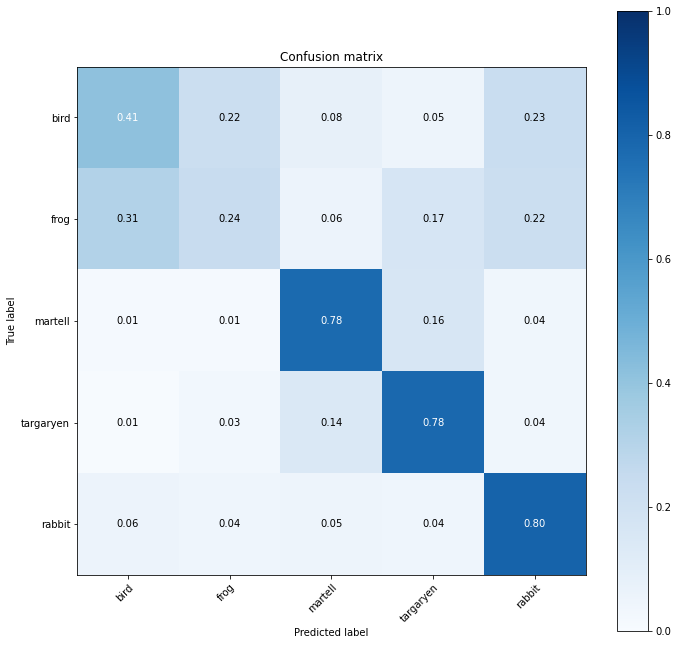

In [5]:
# # what data to use, specify here 
metadata = sounds_metadata_extended
print('Keys: ', list(metadata.columns))
colonies = 'all'
#colonies that specified here are used to train classifer
weights = 'all'
dates = 'all'
separate_colonies_dates = False
sexes = 'all' # options:('M'), ('F'), 'all'
ages = 'all' # options: [180, np.inf], in days
ages_foster = (180, np.inf) # specifies ages of foster pups
ranks = 'all' # options: ('rank1', 'rank2', 'rank3', 'rank4', 'rank5')
ratids = 'all' # can specify indivudals here
bodylengths = 'all' # options: (0, np.inf), all # snout to tail length measured
bodylengths2 ='all' # options: (0, np.inf), all # snout to rump length measured

foster_ids = ['4057', '4075', '3523', '3481', '3513']
foster_ids = []
#4075= daenerys, 4057 = johnsnown, 3523= missandei, 3481 = obara, 3512 = nymeria
exclude_rats = [] # option to exclude individuals here
sounds_per_rat = [20, 1000]
#'single', 'pairs', 'all'
types = 'all'

features_to_classify = ['slope', 'frequency', 'pitch', 'asymmetry', 
                        'wiener_entropy', 'zero_crossings', 'duration', 'height']
classify_by = 'colony'
#classify_by options: 'ratids', 'colony', 'epoch'
group_by = 'ratids' #'ratids' #None, 'ratids', 'date' #specifies how training and test data is split
#NB: you must group by 'ratids' when testing colony dialect 
balance = True #balances number of soft chirps across classes
cv_n_folds = 3 #more cross-validation (c-v) folds are generally better
analyse_fosters = False
#set analyse_fosters = False; when testing for rank, sex, ratids, body-length, weight
#cmap options: plt.cm.Blues, plt.cm.Purples, plt.cm.Oranges, plt.cm.Reds, plt.cm.OrRd
cmap = plt.cm.Blues


order = ORDER[classify_by]
#specifies order of classes and colors that plotted
color = COLOR[classify_by]
color_dict = COLOR[classify_by]



mask =  filter_sounds_metadata_extended(metadata, ratids, foster_ids + exclude_rats, 
                                   types, colonies, weights, sexes, ages, ranks, dates,
                                   bodylengths, bodylengths2, sounds_per_rat)
if separate_colonies_dates:
    mask = mask & separate_date_masks
    
foster_colonies = 'all'
# if you want to change other filters for foster, hust change values in the function call below
mask_foster = filter_sounds_metadata_extended(metadata, foster_ids,
                                         None, types, foster_colonies, weights, sexes, ages_foster, ranks, dates,
                                         bodylengths, bodylengths2, 'all')
#set = to True here for binning of weights, body lengths for classifer (first) or group_by (second) 
if False:  # BINNING OF CLASSIFY COLUMN
    binsize = 10
    mask_index = metadata[mask].index
    metadata.loc[mask_index, classify_by] = make_bins(metadata[mask][classify_by], binsize)
if False:  # BINNING OF GROUP COLUMN
    binsize = 10 
    metadata[mask][group_by] = make_bins(metadata[mask][group_by], binsize)
    
print_info = False
clf, foster_probs, y_unique, y_unique_foster = classify(features, metadata, mask, mask_foster, 
                                                        order, classify_by,  features_to_classify, group_by,
                                                        balance, cv_n_folds, analyse_fosters, print_info, cmap)
print('\nFeatures importances:', )
for fn, fimp in zip(features_to_classify, clf.feature_importances_):
    print('%s: %.3f' % (fn, fimp))

if analyse_fosters:
    prediction = clf.predict_proba(features[features_to_classify][mask_foster])
    prediction = np.concatenate([prediction, 
                                 np.zeros((len(prediction), len(y_unique_foster) - len(y_unique)))], 1)
    foster_predictions = pd.DataFrame(prediction, columns = y_unique_foster)
    foster_predictions['ratids'] = metadata[mask_foster]['ratids'].reset_index(drop = True)
    foster_predictions['age'] = metadata[mask_foster]['age'].reset_index(drop = True)
plt.savefig("test.svg", format="svg")

In [6]:
ratid = '4075'
assert ratid in foster_ids, 'Ratid is not in foster_ids in the cell above!'
age_groups = [[0, 30],[30,60], [60, 90], [90, 180], [180,360], [360,720]]
if analyse_fosters:
    plot_pup_accent_development(ratid, age_groups, foster_predictions, y_unique_foster, color_dict)
    _ = plt.ylim([0,1]) # set y axis range

    #plt.savefig("test2.svg", format="svg")

AssertionError: Ratid is not in foster_ids in the cell above!

In [ ]:
labels = y_unique_foster
colors = [COLOR['colony'][c] for c in y_unique_foster]

In [ ]:
# Plots a pie chart with the probability of each foster pup belonging to the tested colonies
if analyse_fosters:
    plt.figure(figsize = (17, 17))
    figname = 'test3.svg'
    N_fosters = len(foster_ids)
    for i, ratid in enumerate(foster_ids):
        plt.subplot(1, N_fosters, i + 1)
        rat_predictions = foster_predictions[foster_predictions['ratids'] == ratid]
        _ = plt.pie([np.mean(rat_predictions[c]) for c in y_unique_foster], 
                    labels = y_unique_foster, colors = [COLOR['colony'][c] for c in y_unique_foster], 
                    autopct = '%.2f', textprops={'color' : "black", 'fontsize' : 7})
        plt.title(ratid)

    #plt.savefig("new_artificial_playback_FINAL!!_sept2020_updated_colony_classification_arryn_baratheon_dothrakib_targaryen.svg", format="svg")

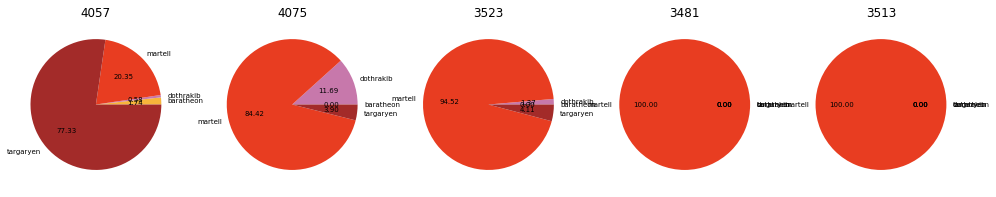

In [36]:

# Plots a pie chart ACCURACIES
if analyse_fosters:
    plt.figure(figsize = (17, 17))
    figname = 'test.svg'
    N_fosters = len(foster_ids)
    for i, ratid in enumerate(foster_ids):
        plt.subplot(1, N_fosters, i + 1)
        rat_predictions = foster_predictions[foster_predictions['ratids'] == ratid]
        rat_predictions_colony = np.bincount(np.argmax(rat_predictions[y_unique_foster].values, 1)) / len(rat_predictions)
        if len(rat_predictions_colony) < len(y_unique_foster):
            rat_predictions_colony = np.concatenate([rat_predictions_colony, 
                                                     np.zeros(len(y_unique_foster) - len(rat_predictions_colony))])
        _ = plt.pie([rat_predictions_colony[ind] for ind in range(len(y_unique_foster))], 
                    labels = y_unique_foster, colors = [COLOR['colony'][c] for c in y_unique_foster], 
                    autopct = '%.2f', textprops={'color' : "black", 'fontsize' : 7})
        plt.title(ratid)
plt.savefig("test4", format="svg")
    